In [33]:
import math
import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt

#%matplotlib inline
#%load_ext autoreload
#%autoreload 2

In [34]:
# # Training data is 100 points in [0,1] inclusive regularly spaced
# Theta1 = np.linspace(-2,2,10)
# Theta2 = np.linspace(-2,2,10)
# mesh = np.array(np.meshgrid(Theta1, Theta2))
# x = torch.tensor(np.linspace(-2,2,100))


# train_T = torch.tensor(mesh.T.reshape(-1, 2))

# noise_mean = 0
# noise_std = 0.1**2
# Theta_True = torch.tensor([1,-1])
# noise = torch.tensor(np.random.normal(size=len(x),loc = noise_mean, scale = noise_std))

# # True function is y=T1*x + T2*x^2 + x^3 with Gaussian noise
# y_true =  Theta_True[0]*x + Theta_True[1]*x**2 +x**3 + noise

# train_y = torch.tensor(np.zeros(len(train_T)))
# #This will change to using pairs i and j in rows of a full theta with all combinations to get all the training data
# for i in range(len(train_T)):
#     for j in range(len(train_T)):
#         y_exp = train_T[i,0]*x + train_T[j,1]*x**2 +x**3
#         train_y[i] = (y_true[i] - y_exp[i])**2
# print(train_y)

In [35]:
# Training data is 15^2 points in [-2,2] inclusive regularly spaced
Theta1 = np.linspace(-2,2,10)
Theta2 = np.linspace(-2,2,10)
mesh = np.array(np.meshgrid(Theta1, Theta2))
x = torch.tensor(np.linspace(-2,2,5))

train_T = torch.tensor(mesh.T.reshape(-1, 2))


noise_mean = 0
noise_std = 0.1**2
Theta_True = torch.tensor([1,-1])
noise = torch.tensor(np.random.normal(size=len(x),loc = noise_mean, scale = noise_std))
#Does Likelihood/defining the class add the noise for me?

# True function is y=T1*x + T2*x^2 + x^3 with Gaussian noise
y_true =  Theta_True[0]*x + Theta_True[1]*x**2 +x**3 + noise

# train_y = torch.tensor(np.zeros([len(train_T),len(x)]))
# #Need a for loop to allow all any x to be considered when GP is ran
# for i in range(len(train_T)):
#     for j in range(len(x)):
#         y_true =  Theta_True[0]*x[j] + Theta_True[1]*x[j]**2 +x[j]**3 + torch.randn(x[j].size()) * noise_std
#         y_exp = train_T[i,0]*x[j] + train_T[i,1]*x[j]**2 +x[j]**3
#         print((y_true - y_exp)**2)
#         train_y[i,j] = (y_true - y_exp)**2

train_y = torch.tensor(np.zeros(len(train_T)))
for i in range(len(train_T)):
    y_exp = train_T[i,0]*x + train_T[i,1]*x**2 +x**3
    train_y[i] = sum((y_true - y_exp)**2)


In [36]:
# mesh = np.array(np.meshgrid(Theta1, Theta2))
# combinations = mesh.T.reshape(-1, 2)
# print(combinations)

In [37]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_T, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_T, train_y, likelihood)
        #What exactly is the mean and covariance of the GP model?
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_T, train_y, likelihood)

In [38]:
# Find optimal model hyperparameters
training_iter = 300

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters 
#Should I change lr? How do I know what would be best?

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_T)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
#     print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
#         i + 1, training_iter, loss.item(),
#         model.covar_module.base_kernel.lengthscale.item(),
#          model.likelihood.noise.item()
#     ))
    optimizer.step()

In [39]:
# How do I print the best hyperparameters?

In [45]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()
test_Theta1 =  np.linspace(-2,2,5)
test_Theta2 =  np.linspace(-2,2,5)
mesh = np.array(np.meshgrid(test_Theta1, test_Theta2))

# Test points are regularly spaced along [-2,2]
# Make predictions by feeding model through likelihood

# with torch.no_grad(), gpytorch.settings.fast_pred_var():
#     test_T = torch.tensor(mesh.T.reshape(-1, 2))
#     observed_pred = likelihood(model(test_T))

In [41]:
# SSE = []
# for i in range(len(observed_pred.loc)):
#     SSE.append(observed_pred.loc[i].item())
# SSE = torch.tensor(SSE)

In [52]:
def sse_func(mesh):
    '''
    Function to define define sum of squared error function for heat map
    Arguments:
        xx: An N X D array of all Theta1 values
            
        yy: An D X N array of all Theta2 values
        theta: parameter vector
        x: independent variable vector (predicted x values including noise)
        y: dependent variable vector (predicted y values on Heat Map)
    Returns:
        sse: N x N sum of squared error matrix of all generated combination of xx and yy
    '''
    sse = np.zeros([len(test_Theta1),len(test_Theta2)])
   
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_T = torch.tensor(mesh.T.reshape(-1, 2))
        observed_pred = likelihood(model(test_T))
    #print(test_T)
    #print(observed_pred.loc)
    sse = observed_pred.loc.reshape(len(test_Theta1),-1)  #How to write this line?
    #sse[i][j] = (observed_pred.loc[k].item())
    
    return sse

xx , yy = np.array(np.meshgrid(test_Theta1, test_Theta2))
zz = sse_func(mesh)

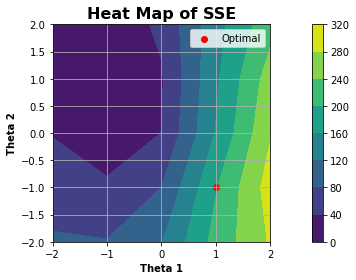

In [55]:
# plot fheatmap
plt.contourf(xx, yy, zz)
plt.colorbar()
plt.scatter(Theta_True[0],Theta_True[1], color="red", label = "Optimal")
plt.axis('scaled')
plt.grid()
plt.legend(loc = 'best')
plt.xlabel('Theta 1',weight='bold')
plt.ylabel('Theta 2',weight='bold')
plt.title('Heat Map of SSE', weight='bold',fontsize = 16)
plt.show()